In [172]:
import json
from collections import defaultdict
import itertools
from operator import itemgetter

import pandas as pd

%matplotlib inline

In [175]:
train_file = '../data/deft_split/jsonl/train.jsonl'
dev_file = '../data/deft_split/jsonl/dev.jsonl'
test_file = '../data/deft_split/jsonl/test.jsonl'

In [176]:
def extract_relations(example):
    relation_labels = example['relations']
    relation_roots = example['relation_roots']
    ner_ids = example['ner_ids']
    relations = zip(ner_ids, relation_roots, relation_labels)
    relations = filter(lambda x: x[2] != '0' and x[1] != -1, relations)
    relations = map(lambda x: (x[0], ner_ids.index(x[0]), x[1], ner_ids.index(x[1]), x[2]), relations)
    return set(relations)

def is_inter_sentence(spans, relation):
    head_idx = relation[3]
    tail_idx = relation[1]
    head_span = list(filter(lambda s: s[0] <= head_idx < s[1], spans))
    tail_span = list(filter(lambda s: s[0] <= tail_idx < s[1], spans))
    return head_span != tail_span

def get_inter_sentence_relations(spans, relations):
    return list(filter(lambda x: is_inter_sentence(spans, x), relations))

def extract_relation_schemes(relations, tags):
    relation_schemes = []
    for relation in relations:
        _, tail_offset, _, head_offset, relation_type = relation
        tail_type = tags[tail_offset][2:]
        head_type = tags[head_offset][2:]
        relation_schemes.append((tail_type, relation_type, head_type))
    return relation_schemes

In [177]:
schemes = None
with open(train_file) as f:
    for line in f.readlines():
        example = json.loads(line)
        if example['id'] == 't6_sociology_0_101.deft##12':
            relations = extract_relations(example)
            schemes = extract_relation_schemes(relations, example['tags'])
schemes

[('Definition', 'Direct-Defines', 'Term')]

In [178]:
inter_sents = None
with open(train_file) as f:
    for line in f.readlines():
        example = json.loads(line)
        if example['id'] == 't6_sociology_0_101.deft##12':
            relations = extract_relations(example)
            sentence_spans = list(map(lambda s: (s['start_token_idx'], s['end_token_idx']), example['sentence_labels']))
            inter_sents = get_inter_sentence_relations(sentence_spans, relations)
            break
inter_sents

[]

In [7]:
def parse_example(example):
    num_relation_types = len(set(example['relations'])) - 1
    tags = list(map(lambda x: x[2:] if x != 'O' else x, example['tags']))
    entities = set(filter(lambda x: x[1] != 'O', zip(example['ner_ids'], tags)))
    entity_types = list(map(itemgetter(1), entities))
    has_inter_sentence_relation = False
    sentence_labels = example['sentence_labels']
    has_def = any(map(lambda s: s['label'] == 'HasDef', sentence_labels))
    sentence_spans = list(map(lambda s: (s['start_token_idx'], s['end_token_idx']), sentence_labels))
    relations = extract_relations(example)
    relation_types = list(map(itemgetter(4), relations))
    relation_schemes = extract_relation_schemes(relations, example['tags'])
    inter_sentence_relations = get_inter_sentence_relations(sentence_spans, relations)
    inter_sentence_relation_types = list(map(lambda r: r[-1], inter_sentence_relations))
    return {
        'id': example['id'],
        'num_sents': len(sentence_labels),
        'num_tokens': len(example['tokens']),
        'num_entities': len(entities),
        'num_relation_types': num_relation_types,
        'num_relations': len(relations),
        'relation_types': relation_types,
        'relation_schemes': relation_schemes,
        'entity_types': entity_types,
        'has_def': has_def,
        'num_inter_sentence_relations': len(inter_sentence_relations),
        'inter_sentence_relation_types': inter_sentence_relation_types,
        'entities': list(entities),
        'relations': list(relations),
    }

In [8]:
def parse_df(file_name):
    rows = []
    with open(file_name, 'r') as f:
        for line in f.readlines():
            rows.append(parse_example(json.loads(line)))
    return pd.DataFrame(rows)

In [9]:
df = parse_df(train_file)
#df.head()

## What is the size of the dataset?

In [11]:
len(df)

6261

In [12]:
df['num_sents'].describe()

count    6261.000000
mean        2.497205
std         0.631343
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         3.000000
Name: num_sents, dtype: float64

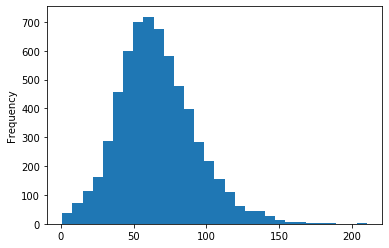

In [13]:
df['num_tokens'].plot.hist(bins=30)

In [14]:
df['num_tokens'].describe()

count    6261.000000
mean       65.831497
std        26.664000
min         1.000000
25%        48.000000
50%        63.000000
75%        82.000000
max       210.000000
Name: num_tokens, dtype: float64

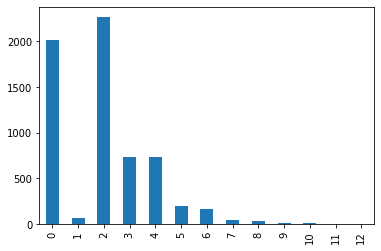

In [15]:
df['num_entities'].value_counts().sort_index().plot.bar()

In [16]:
df['num_entities'].describe()

count    6261.000000
mean        1.982750
std         1.766214
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max        12.000000
Name: num_entities, dtype: float64

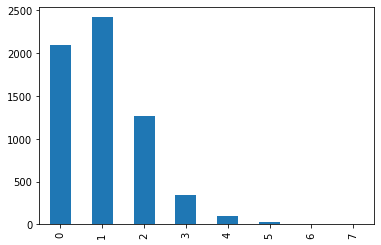

In [17]:
df['num_relations'].value_counts().sort_index().plot.bar()

In [18]:
df['num_relations'].describe()

count    6261.000000
mean        1.047596
std         0.996465
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: num_relations, dtype: float64

## How common are the entity types?

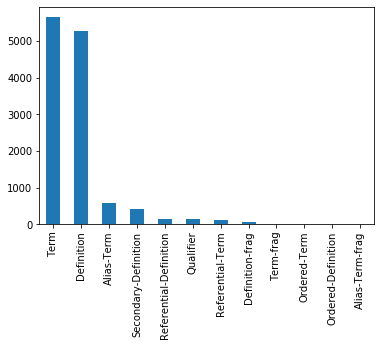

In [19]:
entity_type_counts = df.query('num_entities > 0')['entity_types'].explode().value_counts()
entity_type_counts.plot.bar()

In [20]:
entity_type_counts

Term                      5651
Definition                5280
Alias-Term                 589
Secondary-Definition       406
Referential-Definition     139
Qualifier                  135
Referential-Term           119
Definition-frag             76
Term-frag                    7
Ordered-Term                 5
Ordered-Definition           5
Alias-Term-frag              2
Name: entity_types, dtype: int64

## How common are the relation types?

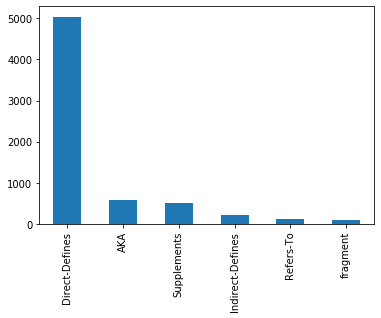

In [21]:
relation_type_counts = df.query('num_relations > 0')['relation_types'].explode().value_counts()
relation_type_counts.plot.bar()

In [22]:
relation_type_counts

Direct-Defines      5035
AKA                  584
Supplements          511
Indirect-Defines     215
Refers-To            130
fragment              84
Name: relation_types, dtype: int64

## How many relations span more than a single sentence?

In [23]:
total_inter_sentence_relations = df['num_inter_sentence_relations'].sum()
total_inter_sentence_relations

622

In [24]:
(total_inter_sentence_relations / df['num_relations'].sum()) * 100

9.483152919652387

## Which relation types span more than a single sentence?

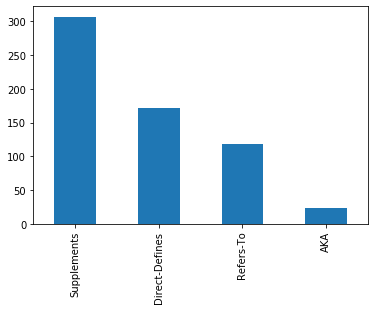

In [25]:
inter_sentence_relation_type_counts = df.query('num_inter_sentence_relations > 0')['inter_sentence_relation_types'].explode().value_counts()
inter_sentence_relation_type_counts.plot.bar()

In [26]:
inter_sentence_relation_type_counts

Supplements       307
Direct-Defines    172
Refers-To         119
AKA                24
Name: inter_sentence_relation_types, dtype: int64

## What are the most common relation signatures?

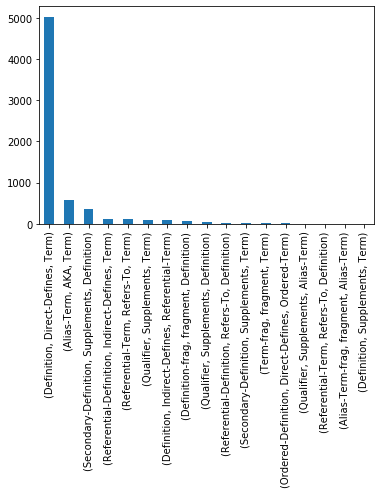

In [27]:
relation_schema_counts=df.query('num_relations > 0')['relation_schemes'].explode().value_counts()
relation_schema_counts.plot.bar()

In [28]:
relation_schema_counts

(Definition, Direct-Defines, Term)                    5030
(Alias-Term, AKA, Term)                                584
(Secondary-Definition, Supplements, Definition)        367
(Referential-Definition, Indirect-Defines, Term)       123
(Referential-Term, Refers-To, Term)                    113
(Qualifier, Supplements, Term)                          93
(Definition, Indirect-Defines, Referential-Term)        92
(Definition-frag, fragment, Definition)                 75
(Qualifier, Supplements, Definition)                    39
(Referential-Definition, Refers-To, Definition)         15
(Secondary-Definition, Supplements, Term)                8
(Term-frag, fragment, Term)                              7
(Ordered-Definition, Direct-Defines, Ordered-Term)       5
(Qualifier, Supplements, Alias-Term)                     3
(Referential-Term, Refers-To, Definition)                2
(Alias-Term-frag, fragment, Alias-Term)                  2
(Definition, Supplements, Term)                         

## Are there any negative examples for the relation extraction?

In [29]:
relations = set()
relations_to_schemas = defaultdict(list)
for schema in relation_schema_counts.index:
    relations_to_schemas[schema[1]].append(schema)
#relations_to_schemas

In [30]:
def count_negatives(schemas, row):
    entities = row['entities']
    relations = row['relations']
    relations = [(r[0], r[2]) for r in relations]
    negative_examples = 0
    for schema in schemas:
        head_type, _, tail_type = schema
        potential_heads = [e[0] for e in entities if e[1] == head_type]
        potential_tails = [e[0] for e in entities if e[1] == tail_type]
        potential_assignments = list(itertools.product(potential_heads, potential_tails))
        free_assignments = [pa for pa in potential_assignments if pa not in relations]
        negative_examples += len(free_assignments)
    return negative_examples

In [31]:
relations_to_negatives = defaultdict(int)
for relation, schemas in relations_to_schemas.items():
    for idx, row in df.iterrows():
        relations_to_negatives[relation] += count_negatives(schemas, row)

In [32]:
relations_to_negatives

defaultdict(int,
            {'Direct-Defines': 3408,
             'AKA': 309,
             'Supplements': 4333,
             'Indirect-Defines': 105,
             'Refers-To': 304,
             'fragment': 42})

## How good is the created split?

In [179]:
train_df = parse_df(train_file)
dev_df = parse_df(dev_file)
test_df = parse_df(test_file)
train_df['split'] = 'train'
dev_df['split'] = 'dev'
test_df['split'] = 'test'
split_df = pd.concat([train_df, dev_df, test_df])

In [180]:
split_df[['split',
          'num_sents',
          'num_tokens',
          'num_entities',
          'num_relations',
          'num_inter_sentence_relations']].groupby('split').describe().transpose()

split                                      dev        test        train
num_sents                    count  733.000000  344.000000  6261.000000
                             mean     2.489768    2.482558     2.497205
                             std      0.660325    0.682764     0.631343
                             min      1.000000    1.000000     1.000000
                             25%      2.000000    2.000000     2.000000
                             50%      3.000000    3.000000     3.000000
                             75%      3.000000    3.000000     3.000000
                             max      3.000000    3.000000     3.000000
num_tokens                   count  733.000000  344.000000  6261.000000
                             mean    64.705321   63.933140    65.831497
                             std     27.784208   26.229391    26.664000
                             min      1.000000    2.000000     1.000000
                             25%     46.000000   46.000000    48.000000
                             50%     62.000000   64.000000    63.000000
                             75%     81.000000   79.000000    82.000000
                             max    184.000000  162.000000   210.000000
num_entities                 count  733.000000  344.000000  6261.000000
                             mean     1.912688    1.886628     1.982750
                             std      1.856318    1.848945     1.766214
                             min      0.000000    0.000000     0.000000
                             25%      0.000000    0.000000     0.000000
                             50%      2.000000    2.000000     2.000000
                             75%      3.000000    3.000000     3.000000
                             max     12.000000   10.000000    12.000000
num_relations                count  733.000000  344.000000  6261.000000
                             mean     1.000000    0.965116     1.047596
                             std      1.048027    0.995004     0.996465
                             min      0.000000    0.000000     0.000000
                             25%      0.000000    0.000000     0.000000
                             50%      1.000000    1.000000     1.000000
                             75%      2.000000    2.000000     2.000000
                             max      6.000000    5.000000     7.000000
num_inter_sentence_relations count  733.000000  344.000000  6261.000000
                             mean     0.085948    0.075581     0.099345
                             std      0.290057    0.264712     0.329635
                             min      0.000000    0.000000     0.000000
                             25%      0.000000    0.000000     0.000000
                             50%      0.000000    0.000000     0.000000
                             75%      0.000000    0.000000     0.000000
                             max      2.000000    1.000000     4.000000

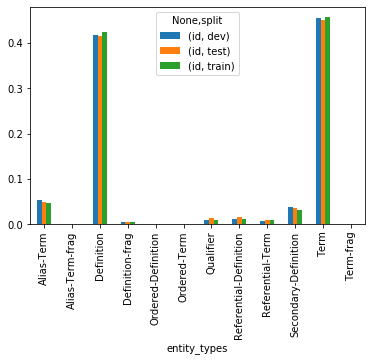

In [200]:
entity_types_by_split = split_df.query('num_entities > 0')[['split', 'entity_types', 'id']].explode('entity_types').groupby(['split', 'entity_types']).count()
entity_types_by_split = entity_types_by_split.unstack(level=0)
(entity_types_by_split/entity_types_by_split.sum()).plot.bar()

In [214]:
entity_types_by_split.sort_values(by=('id','train'), ascending=False)['id'][['train', 'dev', 'test']]

split,train,dev,test
entity_types,,,
Term,6385.0,1410.0,778.0
Definition,5943.0,1293.0,715.0
Alias-Term,671.0,164.0,86.0
Secondary-Definition,454.0,119.0,64.0
Referential-Definition,154.0,36.0,27.0
Qualifier,145.0,33.0,25.0
Referential-Term,134.0,25.0,15.0
Definition-frag,83.0,18.0,10.0
Term-frag,7.0,2.0,NaN


In [213]:
#print(entity_types_by_split.sort_values(by=('id','train'), ascending=False)['id'][['train', 'dev', 'test']].fillna(0).astype('int64').to_latex())

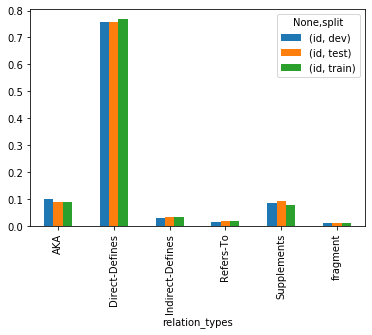

In [182]:
relation_types_by_split = split_df.query('num_relations > 0')[['split', 'relation_types', 'id']].explode('relation_types').groupby(['split', 'relation_types']).count()
relation_types_by_split = relation_types_by_split.unstack(level=0)
relation_types_by_split = relation_types_by_split/relation_types_by_split.sum()
relation_types_by_split.plot.bar()

In [36]:
relation_types_by_split

id          
split                  dev     train
relation_types                      
AKA               0.106956  0.091255
Direct-Defines    0.742708  0.765526
Indirect-Defines  0.030666  0.033235
Refers-To         0.017203  0.019856
Supplements       0.088257  0.077454
fragment          0.014211  0.012674

## Find a good example for the paper

In [43]:
df.sort_values(by='num_relations', ascending=False).head()

,id,num_sents,num_tokens,num_entities,num_relation_types,num_relations,relation_types,relation_schemes,entity_types,has_def,num_inter_sentence_relations,inter_sentence_relation_types,entities,relations
351,t1_biology_0_202.deft##35,3,89,12,4,7,"[Direct-Defines, fragment, Supplements, Direct...","[(Definition, Direct-Defines, Term), (Term-fra...","[Term, Term, Definition, Definition, Referenti...",True,1,[Supplements],"[(T132, Term), (T130, Term), (T133, Definition...","[(T131, 67, T130, 65, Direct-Defines), (T126-f..."
200,t1_biology_0_101.deft##81,2,99,11,2,6,"[Supplements, Direct-Defines, Supplements, Sup...","[(Qualifier, Supplements, Term), (Definition, ...","[Term, Qualifier, Term, Qualifier, Term, Quali...",True,0,[],"[(T13, Term), (T305, Qualifier), (T303, Term),...","[(T306, 42, T303, 48, Supplements), (T14, 21, ..."
84,t1_biology_0_0.deft##84,2,130,8,3,6,"[Supplements, Supplements, AKA, AKA, Supplemen...","[(Qualifier, Supplements, Term), (Qualifier, S...","[Qualifier, Definition, Referential-Definition...",True,1,[Refers-To],"[(T268, Qualifier), (T249, Definition), (T267,...","[(T268, 69, T266, 64, Supplements), (T272, 110..."
750,t1_biology_0_404.deft##27,3,63,10,3,6,"[AKA, Indirect-Defines, Direct-Defines, Direct...","[(Alias-Term, AKA, Term), (Referential-Definit...","[Term, Term, Alias-Term, Referential-Definitio...",True,0,[],"[(T92, Term), (T95, Term), (T96, Alias-Term), ...","[(T93, 8, T92, 2, AKA), (T100, 37, T101, 41, I..."
1784,t1_biology_1_404.deft##32,3,88,10,3,6,"[Direct-Defines, Direct-Defines, Direct-Define...","[(Definition, Direct-Defines, Term), (Definiti...","[Definition, Definition, Definition, Term, Ter...",True,0,[],"[(T126, Definition), (T130, Definition), (T128...","[(T128, 42, T129, 49, Direct-Defines), (T125, ..."


In [76]:
paper_example = None
with open(train_file) as f:
    for line in f.readlines():
        example = json.loads(line)
        if example['id'] == 't1_biology_0_404.deft##27':
            paper_example = example

In [77]:
" ".join(paper_example['tokens'])

'1295 . A frontal plane ( also called a coronal plane ) separates the front from the back . A transverse plane ( or , horizontal plane ) divides the animal into upper and lower portions . This is sometimes called a cross section , and , if the transverse cut is at an angle , it is called an oblique plane .'

In [78]:
set((head, rel) for head, rel in zip(paper_example['relation_roots'],paper_example['relations']) if rel != '0')

{('T101', 'Indirect-Defines'),
 ('T92', 'AKA'),
 ('T92', 'Direct-Defines'),
 ('T95', 'AKA'),
 ('T95', 'Direct-Defines'),
 ('T98', 'Direct-Defines')}

In [79]:
paper_example.keys()

dict_keys(['tokens', 'start_chars', 'end_chars', 'tags', 'ner_ids', 'relation_roots', 'relations', 'spacy_pos', 'spacy_tag', 'spacy_dep_head', 'spacy_dep_rel', 'spacy_pattern_is_reference', 'spacy_pattern_is_definition', 'spacy_pattern_is_alias', 'spacy_pattern_noisy_alias', 'spacy_pattern_reference_keywords', 'coref_top_spans', 'coref_predicted_antecedents', 'coref_clusters', 'sentence_labels', 'id'])

In [143]:
def example_to_text(example):
    text = ""
    example_offset = int(example['start_chars'][0])
    for token, start_idx in zip(example['tokens'], example['start_chars']):
        start_idx = int(start_idx) - example_offset
        assert start_idx >= len(text)
        while start_idx > len(text):
            text += " "
        text += token
    return text

In [156]:
text = example_to_text(paper_example)
text

'1295. A frontal plane (also called a coronal plane) separates the front from the back.         A transverse plane (or, horizontal plane) divides the animal into upper and lower portions.       This is sometimes called a cross section, and, if the transverse cut is at an angle, it is called an oblique plane.'

In [157]:
pe = paper_example
offset = pe['start_chars'][0]
for tag, tok, start, end in zip(pe['tags'], pe['tokens'], pe['start_chars'], pe['end_chars']):
    if tag == 'O':
        continue
    s = int(start) - int(offset)
    e = int(end) - int(offset)
    print(tag, tok, s, e, text[s:e])

B-Term A 6 7 A
I-Term frontal 8 15 frontal
I-Term plane 16 21 plane
B-Alias-Term a 35 36 a
I-Alias-Term coronal 37 44 coronal
I-Alias-Term plane 45 50 plane
B-Definition separates 52 61 separates
I-Definition the 62 65 the
I-Definition front 66 71 front
I-Definition from 72 76 from
I-Definition the 77 80 the
I-Definition back 81 85 back
B-Term A 95 96 A
I-Term transverse 97 107 transverse
I-Term plane 108 113 plane
B-Alias-Term horizontal 119 129 horizontal
I-Alias-Term plane 130 135 plane
B-Definition divides 137 144 divides
I-Definition the 145 148 the
I-Definition animal 149 155 animal
I-Definition into 156 160 into
I-Definition upper 161 166 upper
I-Definition and 167 170 and
I-Definition lower 171 176 lower
I-Definition portions 177 185 portions
B-Referential-Definition This 193 197 This
B-Term a 218 219 a
I-Term cross 220 225 cross
I-Term section 226 233 section
B-Definition the 243 246 the
I-Definition transverse 247 257 transverse
I-Definition cut 258 261 cut
I-Definition is 26

In [169]:
pe = paper_example
offset = pe['start_chars'][0]
for nid, tag, tok, start, end in zip(pe['ner_ids'], pe['tags'], pe['tokens'], pe['start_chars'], pe['end_chars']):
    if tag == 'O':
        continue
    s = int(start) - int(offset)
    e = int(end) - int(offset)
    print(nid, tag, tok, s, e, text[s:e])

T92 B-Term A 6 7 A
T92 I-Term frontal 8 15 frontal
T92 I-Term plane 16 21 plane
T93 B-Alias-Term a 35 36 a
T93 I-Alias-Term coronal 37 44 coronal
T93 I-Alias-Term plane 45 50 plane
T94 B-Definition separates 52 61 separates
T94 I-Definition the 62 65 the
T94 I-Definition front 66 71 front
T94 I-Definition from 72 76 from
T94 I-Definition the 77 80 the
T94 I-Definition back 81 85 back
T95 B-Term A 95 96 A
T95 I-Term transverse 97 107 transverse
T95 I-Term plane 108 113 plane
T96 B-Alias-Term horizontal 119 129 horizontal
T96 I-Alias-Term plane 130 135 plane
T97 B-Definition divides 137 144 divides
T97 I-Definition the 145 148 the
T97 I-Definition animal 149 155 animal
T97 I-Definition into 156 160 into
T97 I-Definition upper 161 166 upper
T97 I-Definition and 167 170 and
T97 I-Definition lower 171 176 lower
T97 I-Definition portions 177 185 portions
T100 B-Referential-Definition This 193 197 This
T101 B-Term a 218 219 a
T101 I-Term cross 220 225 cross
T101 I-Term section 226 233 section

In [170]:
rel_idx = 1
for nid, root, rel in set(zip(pe['ner_ids'], pe['relation_roots'], pe['relations'])):
    if root == '-1':
        continue
    print(f"R{rel_idx}\t{rel} Arg1:{nid} Arg2:{root}\t")
    rel_idx += 1

R1	Direct-Defines Arg1:T94 Arg2:T92	
R2	AKA Arg1:T96 Arg2:T95	
R3	Indirect-Defines Arg1:T100 Arg2:T101	
R4	Direct-Defines Arg1:T97 Arg2:T95	
R5	AKA Arg1:T93 Arg2:T92	
R6	Direct-Defines Arg1:T99 Arg2:T98	
